In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt
import pickle

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from pygam import LinearGAM

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set()

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def import_gpd(filename):
    data = pd.read_csv(filename)
    data['geometry'] = data['geometry'].apply(wkt.loads)
    data_gpd = gpd.GeoDataFrame(data, geometry = data['geometry'], crs={'init' :'epsg:4326'})
    data_gpd = data_gpd.drop(['Unnamed: 0'], axis = 1)
    return(data_gpd)

def pred_summary(pred, ytest, limit = 200):
    sns.scatterplot(pred, ytest)
    abline(1, 0) #1-1 line
    plt.ylim(0, limit)
    plt.xlim(0, limit);
    
    print('RMSE', np.sqrt(mean_squared_error(ytest, pred)))
    print('R2', r2_score(ytest, pred))

In [3]:
GSVdf = import_gpd('GSV_zoning_dist.csv')

# create X, y datasets for model
X_vars = ['road_type', 'closest_highway', 'closest_primary', 'closest_secondary', 'corner_dist', 'signal_dist',
         'zone', 'pop_den', 'industry_dist']

X = GSVdf[X_vars]
X = pd.get_dummies(X, columns=['road_type', 'zone']) #create dummy variables for the two categorical features
y = GSVdf['NO2']
print(X.shape, y.shape)

#train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=0)
print(Xtrain.shape)

Xtrain.columns

(18283, 18) (18283,)
(12249, 18)


Index(['closest_highway', 'closest_primary', 'closest_secondary',
       'corner_dist', 'signal_dist', 'pop_den', 'industry_dist',
       'road_type_motorway', 'road_type_primary', 'road_type_residential',
       'road_type_secondary', 'road_type_tertiary', 'road_type_unclassified',
       'zone_commercial', 'zone_industrial', 'zone_open', 'zone_residential',
       'zone_urban'],
      dtype='object')

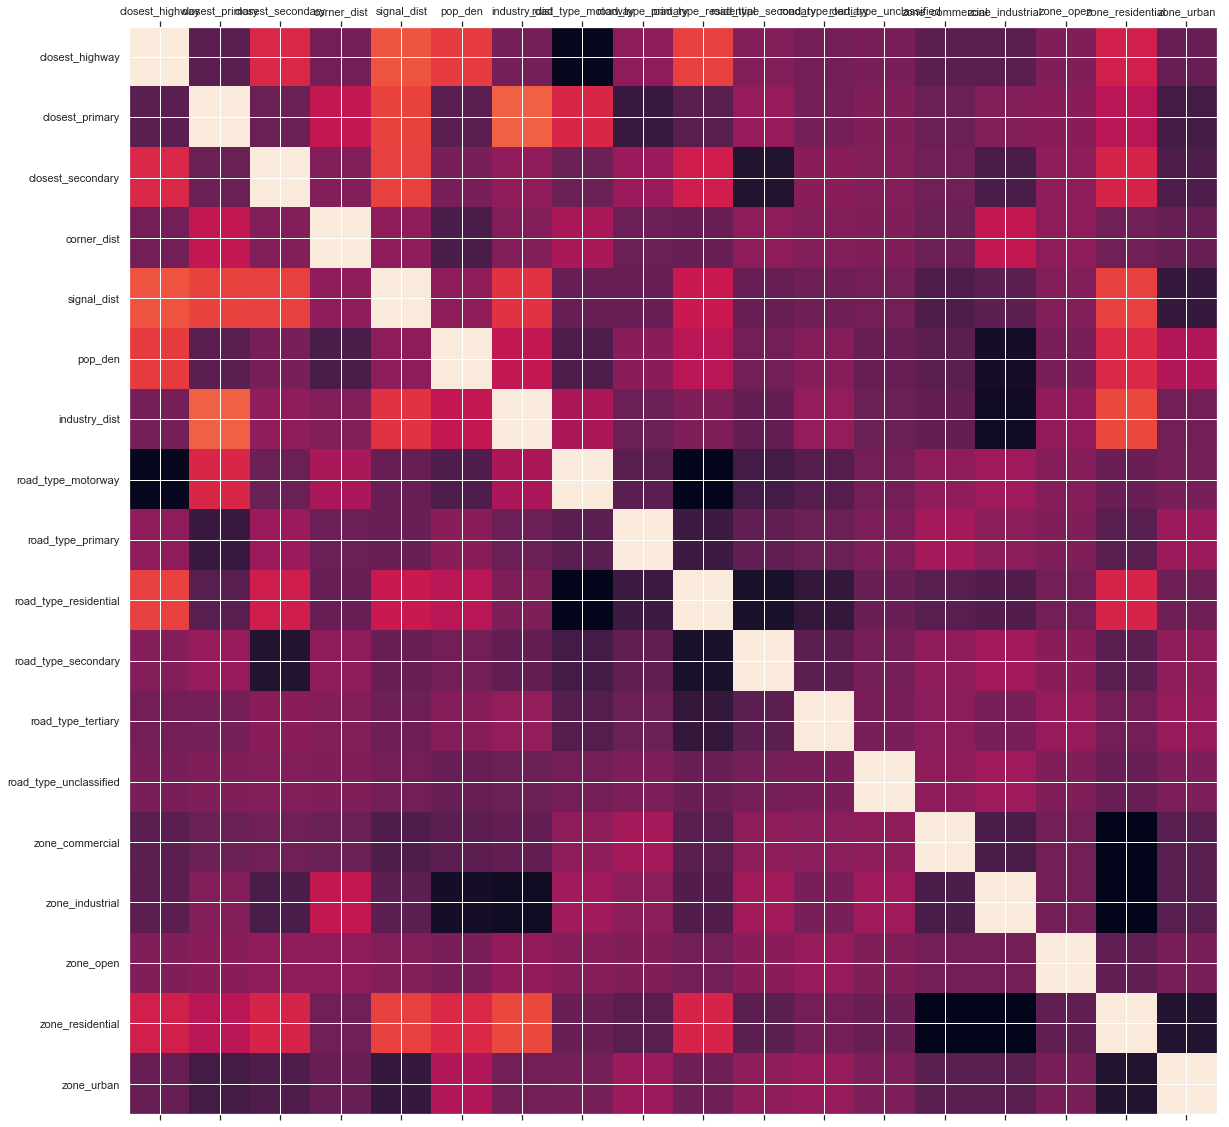

In [4]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color='black')
    

plot_corr(X, size=20)

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


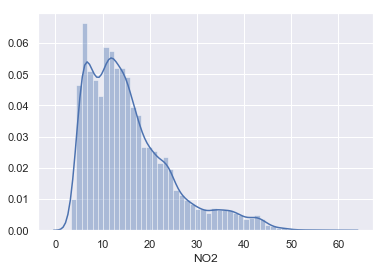

In [5]:
sns.distplot(y)

# Basic models

## 1. Linear models

### Linear model no regularization

In [6]:
linear_reg = make_pipeline(StandardScaler(),
                          LinearRegression())

linear_reg.fit(Xtrain, np.log(ytrain + 0.00001))
cross_val_score(linear_reg, Xtrain, np.log(ytrain + 0.00001), cv=5)

array([0.73879436, 0.74294098, 0.74491223, 0.73058877, 0.74002443])

RMSE 5.138669977292538
R2 0.678926903749921


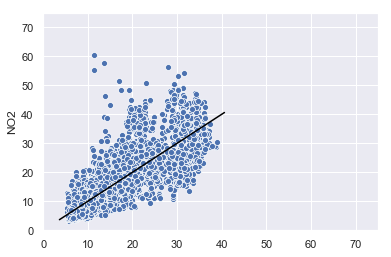

In [7]:
lin_out = linear_reg.predict(Xtest)
sns.scatterplot(np.exp(lin_out), ytest)
abline(1, 0)
plt.ylim(0, 75); plt.xlim(0, 75)

print('RMSE', np.sqrt(mean_squared_error(ytest, np.exp(lin_out))))
print('R2', r2_score(ytest, np.exp(lin_out)))

### Linear modeling with LASSO cost

In [8]:
# setup pipeline and grid search for cost function
lasso = make_pipeline(StandardScaler(),
                          Lasso(max_iter = 10000))
params = {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
lasso_grid = GridSearchCV(lasso, params, cv=5)

#fit the model
lasso_grid.fit(Xtrain, np.log(ytrain + 0.001))

#Best estimator and CV score
print('R2', lasso_grid.best_score_)
print(lasso_grid.best_estimator_)

R2 0.7394491958373952
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])


RMSE 5.137046094244147
R2 0.679129797797809


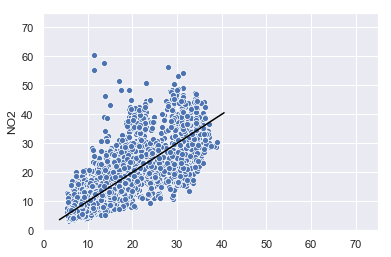

In [17]:
# Evaluate LASSO against the test set
lasso_out = lasso_grid.predict(Xtest)

sns.scatterplot(np.exp(lasso_out), ytest)
abline(1, 0)
plt.ylim(0, 75); plt.xlim(0, 75)

print('RMSE', np.sqrt(mean_squared_error(ytest, np.exp(lasso_out))))
print('R2', r2_score(ytest, np.exp(lasso_out)))

### Generalized additive model

In [9]:
# implement a basic generalized additive model
gam_grid = LinearGAM().gridsearch(Xtrain, ytrain,
                             lam=np.logspace(-3, 3, 11), n_splines=[10, 25, 50])

gam_out = gam_grid.predict(Xtest)

N/A% (0 of 33) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/anaconda3/envs/OSMNX/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
  3% (1 of 33) |                         | Elapsed Time: 0:00:00 ETA:   0:00:16/anaconda3/envs/OSMNX/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
  6% (2 of 33) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:19/anaconda3/en

RMSE 3.804701276065765
R2 0.8239874678467078


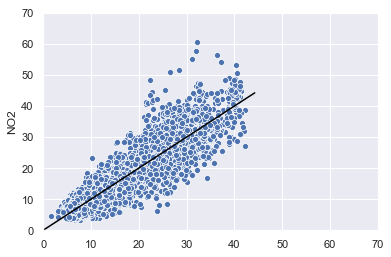

In [11]:
pred_summary(gam_out, ytest, limit=70)

**Takeaway:** None of the linear models do particularly well. In all cases, there is a ceiling with the predictions around 75 units. This is likely due to the lack of interaction terms occuring in any of the linear models

## 2. Tree-based models

### Random Forest

In [12]:
forest = RandomForestRegressor(n_jobs=2)

params = {'max_features': [6, 8, 10],
          'n_estimators': [400, 500, 600]}

forest_grid = GridSearchCV(forest, params, cv=5, scoring = 'neg_mean_squared_error')
forest_grid.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [6, 8, 10], 'n_estimators': [400, 500, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [14]:
print(forest_grid.best_estimator_)
np.sqrt(forest_grid.best_score_*-1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


2.2379175266437215

RMSE 2.185925944155829
R2 0.9419003719653993


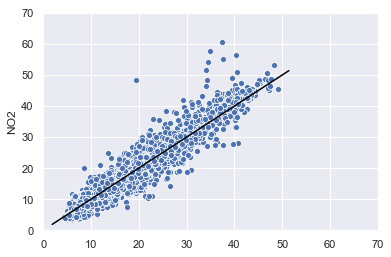

In [15]:
forest_out = forest_grid.predict(Xtest)
pred_summary(forest_out, ytest, limit=70)

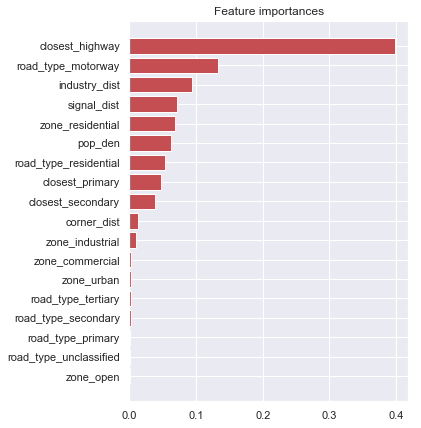

In [16]:
features = X.columns
importance = forest_grid.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances")
plt.barh(features[indices], importance[indices],
       color="r",  align="center");

### Gradient Boosted Tree

In [20]:
# Start simple with many estimators to find and early stopping point...
gbr = GradientBoostingRegressor()
params = {'n_estimators': [200, 400, 600],
          'max_depth': [2, 3, 4],
          'learning_rate': [0.005, 0.01, 0.05]}
gbr_grid = GridSearchCV(gbr, params, cv=5, scoring = 'neg_mean_squared_error')

gbr_grid.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 400, 600], 'max_depth': [2, 3, 4], 'learning_rate': [0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [128]:
print(gbr_grid.best_estimator_)
np.sqrt(gbr_grid.best_score_*-1)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=600, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


2.670154704721042

RMSE 2.6459247520707505
R2 0.9148749380848046


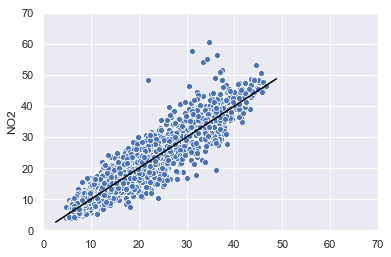

In [129]:
gbr_out = gbr_grid.predict(Xtest)
pred_summary(gbr_out, ytest, limit=70)

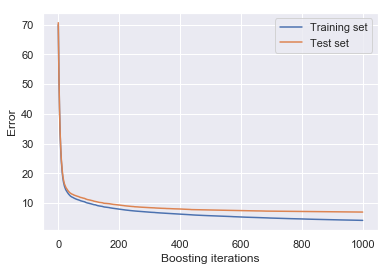

In [109]:
# score by boosting iterations

#calculate for test set
test_score = np.zeros(1000, dtype=np.float64)

for i, y_pred in enumerate(gbr.staged_predict(Xtest)):
    test_score[i] = gbr.loss_(ytest, y_pred)

plt.plot(gbr.train_score_, label='Training set')
plt.plot(test_score, label='Test set')
plt.legend()
plt.xlabel('Boosting iterations'); plt.ylabel('Error');

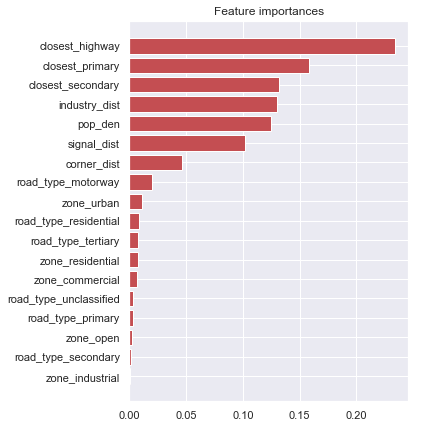

In [130]:
features = X.columns
importance = gbr_grid.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances")
plt.barh(features[indices], importance[indices],
       color="r",  align="center");

In [72]:
sorted(gbr.get_params().keys())

['alpha',
 'criterion',
 'init',
 'learning_rate',
 'loss',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'presort',
 'random_state',
 'subsample',
 'verbose',
 'warm_start']

In [17]:
# pickle the random forest model for now
decision_tree_pkl_filename = 'random_forest.pkl'
# Open the file to save as pkl file
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
pickle.dump(forest_grid.best_estimator_, decision_tree_model_pkl)
# Close the pickle instances
decision_tree_model_pkl.close()